# PyPHS Tutorial 2: The lowpass filter

* Build the graph associated with an **input/output** passive circuit
    * The hard way: use PyPHS `Graph`
    * The easy way: use PyPHS `Netlist`
* Automated graph analysis (`Graph` $\rightarrow$ `Core`)
* Add control parameters
* Simulation and code generation

<img src="files/figures/lowpass_colored_small.png">


* **PyPHS components are `Graph` objects**
* Use [Networkx](https://afalaize.github.io/posts/170614_ulr_python/) for graph structures in Python
* See also the [PyPHS Graph tutorial](https://pyphs.github.io/pyphs/posts/tutos/pyphs-graph/)
* Scientific details:
[Falaize, A., & Hélie, T. (2016). Passive Guaranteed Simulation of Analog Audio Circuits: A Port-Hamiltonian Approach. Applied Sciences, 6(10), 273.](https://afalaize.github.io/publis/P1.pdf)

#### Outline
1. Physical system
2. Building `Graph` objects
    * The hard way: `Graph` object
    * The easy way: `Netlist` object
3. Automated graph analysis (`Graph`$\rightarrow$`Core`)
4. Define control parameters
6. I/O simulations

#### Additionnally

* Code generation (C++, Juce, Faust)

## 1. Physical system (lowpass filter)

<img src="files/figures/lowpass_colored.png">
* 3 nodes: `N1`, `N2`, and datum `#` (ground).
* 5 edges: <span style="color:blue">1 storage C</span>, <span style="color:green">2 dissipations R1, R2</span> , <span style="color:red">2 ports I, O</span>.

## Associated graph
The current (*flow*) indicate the edge direction (**receiver convention**)
<img src="files/figures/lowpass_colored.png">
<img src="files/figures/lowpass_graph.png">

## 2. Building `Graph` objects


* Based on the [networkx.MultiDiGraph object](https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html) (Directed graphs with selfloops).
* Plus a PyPHS `Core` attribute.
* Plus a graph analysis method.

* An edge between `N1`$\rightarrow$`N2` is a tuple 
    ('N1', 'N2', data)
* Edges data depend on the edge type 
    * storage, 
    * dissipation, 
    * source or 
    * connector.
    

### 2.1 Building `Graph` objects: the hard way (script)

1. Instanciate a main graph object
2. Instanciate every components
3. Append (connect) components graphs to main graph

### `Graph` object instanciation
Initialization parameters are optional:
1. `netlist`: a Netlist object or `.net` file (see below)
2. `label`: an identification label

In [1]:
from pyphs import Graph
LPFgraph = Graph(netlist=None, label='lowpass')  # Empty graph (LowPass Filter)

### `Graph` Nodes

* Node labels are unique identifiers.
* Must be Python strings.
* Reference node: **datum** (electrical ground, mechanical reference velocity, etc).

In [2]:
from pyphs import datum
datum                                             

'#'

### `Graph` Edges
* Below are examples of different type of edges taken from the dictionary.
* Recall PyPHS dictionary components are `Graph` objects.

#### <span style="color:blue">Storage edge data</span>

    data = {'type': 'storage',      # edge type (string)
            'label': xC1,           # edge label (Core.symbols)
            'ctrl': 'f',            # ctrl type: 'f' (flow) or 'e' (effort)
            'link': None}           # edge link argument

#### <span style="color:blue">Storage edge example: Capacitor</span>

In [3]:
from pyphs.dictionary.electronics import Capacitor
label = 'C1'                               # component label
nodes = ('N2', datum)                      # edge (current) direction 'N2'->datum
pars = {'C': ('C1', 1e-06)}                # affect symbol 'C1' and value 1e-6 to parameter C
Cgraph = Capacitor(label, nodes, **pars)   # instanciate a capacitor graph object
LPFgraph += Cgraph                         # add capacitor graph to main graph 

In [4]:
LPFgraph.nodeslist                         # set of nodes (unsorted)

{'#', 'N2'}

In [5]:
edges = LPFgraph.edgeslist                 # list of edges
edges[0]                                   # first (only) edge

('N2', '#', {'ctrl': 'f', 'label': xC1, 'link': None, 'type': 'storage'})

#### <span style="color:green">Dissipation edge data</span>


    data = {'type': 'dissipative',        # edge type (string)
            'label': wR1,                 # edge label (Core.symbols)
            'ctrl': '?',                  # flow 'f', effort 'e', indeterminate '?'
            'link': None,                 # edge link argument            
            'z': {'e_ctrl': wR1/R1,       # ctrl-dependent dissipation function
                  'f_ctrl': R1*wR1}}

#### <span style="color:green">Dissipation edge example: Resistor 1</span>

In [6]:
from pyphs.dictionary.electronics import Resistor
label = 'R1'                               # component label
nodes = ('N1', 'N2')                       # edge (current) direction 'N1'->N2
pars = {'R': ('R1', 1e3)}                  # affect symbol 'R1' and value 1e3 to parameter R
R1graph = Resistor(label, nodes, **pars)   # instanciate a resistor graph object
LPFgraph += R1graph                        # add resistor graph to main graph 

In [7]:
LPFgraph.nodeslist                         # set of main graph nodes (unsorted)

{'#', 'N1', 'N2'}

In [8]:
R1graph.edgeslist[0]                       # resistor graph edge

('N1',
 'N2',
 {'ctrl': '?',
  'label': wR1,
  'link': None,
  'type': 'dissipative',
  'z': {'e_ctrl': wR1/R1, 'f_ctrl': R1*wR1}})

#### <span style="color:green">Dissipation edge example: Resistor 2</span>

In [9]:
label = 'R2'                               # component label
nodes = ('N2', datum)                      # edge (current) direction 'N2'->datum
pars = {'R': ('R2', 1e3)}                  # affect symbol 'R2' and value 1e3 to parameter R
R2graph = Resistor(label, nodes, **pars)   # instanciate a resistor graph object
LPFgraph += R2graph                        # add resistor graph to main graph 

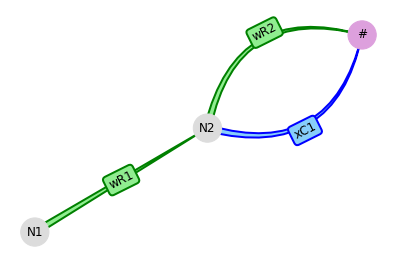

In [10]:
LPFgraph.plot()                            # plot main graph 

#### <span style="color:red">Port edge data</span>

    data = {'type': 'port',         # edge type (string)
            'label': yI,            # edge label (Core.symbols)
            'ctrl': 'f',            # ctrl type for y: 'f' (flow) or 'e' (effort)
            'link': None}           # edge link argument

#### <span style="color:red">Port edge example: input</span>

In [11]:
from pyphs.dictionary.electronics import Source
label = 'I'                                # component label
nodes = ('N1', datum)                      # edge (current) direction 'N1'->datum
pars = {'type': 'voltage'}                 # input u = port voltage
Igraph = Source(label, nodes, **pars)      # instanciate a port graph object
LPFgraph += Igraph                         # add port graph to main graph 

In [12]:
Igraph.edgeslist[0]                        # port edge

('N1', '#', {'ctrl': 'f', 'label': yI, 'link': None, 'type': 'port'})

#### <span style="color:red">Port edge example: output</span>

In [13]:
label = 'O'                                # component label
nodes = ('N2', datum)                      # edge (current) direction 'N1'->datum
pars = {'type': 'current'}                 # input u = port voltage
Ograph = Source(label, nodes, **pars)      # instanciate a port graph object
LPFgraph += Ograph                         # add port graph to main graph 

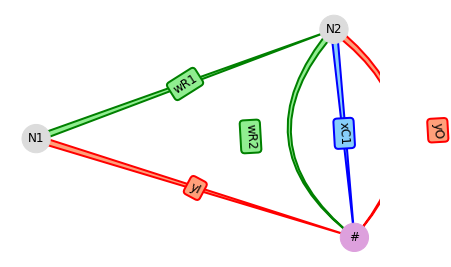

In [14]:
LPFgraph.plot()                            # plot main graph 

### 2.2 Building `Graph` objects: the easy way (netlists)

* Netlists describe graphs (e.g. SPICE netlists).
* The `Netlist` object read and write netlist files `.net`.
* Each line of a netlist instantiate a component.
* Here 


    electronics.source I ('N1', '#'): type=voltage;
    electronics.resistor R1 ('N1', 'N2'): R=('R1', 500.0);
    electronics.capacitor C ('N2', '#'): C=('C', 1e-06);
    electronics.resistor R2 ('N2', '#'): R=('R2', 1000.0);
    electronics.source O ('N2', '#'): type=current;

* **syntax**


    dictionary.component label ('N1', ..., 'Nn'): p1=('s1', v1); p2=('s2', v2);
    
    
    

### Read from `.net` files
Below we read the file `lowpass.net` from current working directory.

In [15]:
import os
path = os.path.join(os.getcwd(), 'lowpass.net')     # Absolute path

In [16]:
from pyphs import Netlist
netlist = Netlist(path)              # Init Netlist with path to '.net' file
print(netlist.netlist())             # print netlist content

electronics.source I ('N1', '#'): type=voltage;
electronics.resistor R1 ('N1', 'N2'): R=('R1', 500.0);
electronics.resistor R2 ('N2', '#'): R=('R2', 1000.0);
electronics.capacitor C ('N2', '#'): C=('C', 1e-06);
electronics.source O ('N2', '#'): type=current;


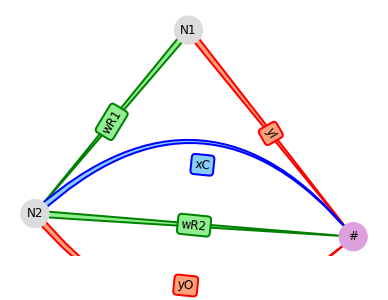

In [17]:
graph = netlist.to_graph()           # Build Graph object from netlist
graph.plot()                         # Plot graph object

## Automated graph analysis (`Graph`$\rightarrow$`Core`)
* Use method `Graph.to_core` to perform analysis and build a `Core` object.
* The graph analysis algorithm is available in 

[Falaize, A., & Hélie, T. (2016). Passive Guaranteed Simulation of Analog Audio Circuits: A Port-Hamiltonian Approach. Applied Sciences, 6(10), 273.](https://afalaize.github.io/publis/P1.pdf)


In [18]:
core = graph.to_core()     # perform graph analysis and produce `Core`object
core.pprint()              # show structure

⎡⎡dxC⎤  ⎡ 0    -1.0  1.0   -1.0   0 ⎤  ⎡gxC⎤⎤
⎢⎢   ⎥  ⎢                           ⎥  ⎢   ⎥⎥
⎢⎢wR₂⎥  ⎢1.0    0     0     0     0 ⎥  ⎢zR₂⎥⎥
⎢⎢   ⎥  ⎢                           ⎥  ⎢   ⎥⎥
⎢⎢wR₁⎥, ⎢-1.0   0     0     0    1.0⎥, ⎢zR₁⎥⎥
⎢⎢   ⎥  ⎢                           ⎥  ⎢   ⎥⎥
⎢⎢yO ⎥  ⎢1.0    0     0     0     0 ⎥  ⎢uO ⎥⎥
⎢⎢   ⎥  ⎢                           ⎥  ⎢   ⎥⎥
⎣⎣yI ⎦  ⎣ 0     0    -1.0   0     0 ⎦  ⎣uI ⎦⎦


In [19]:
core.reduce_z()            # reduce linear dissipation functions in matrix R
core.pprint()              # show structure

⎡       ⎡  1.0   1.0         1.0 ⎤       ⎤
⎢       ⎢- ─── - ───  -1.0   ─── ⎥       ⎥
⎢⎡dxC⎤  ⎢   R₂    R₁          R₁ ⎥  ⎡gxC⎤⎥
⎢⎢   ⎥  ⎢                        ⎥  ⎢   ⎥⎥
⎢⎢yO ⎥, ⎢    1.0       0      0  ⎥, ⎢uO ⎥⎥
⎢⎢   ⎥  ⎢                        ⎥  ⎢   ⎥⎥
⎢⎣yI ⎦  ⎢    1.0            -1.0 ⎥  ⎣uI ⎦⎥
⎢       ⎢    ───       0    ─────⎥       ⎥
⎣       ⎣     R₁              R₁ ⎦       ⎦


## Minimum spanning stree
* Graph analysis succeed if a **minimum spanning stree** is well defined.
* In the plot below: 
    * Nodes are <span style="color:green">green</span> if the potential is well defined, else <span style="color:red">red</span>.
    * Flow-controlled edges are <span style="color:green">green</span> if the realizability is well defined.
    * Effort-controlled edges are **invisible**.
    * Indeterminate edges are <span style="color:red">red</span>.

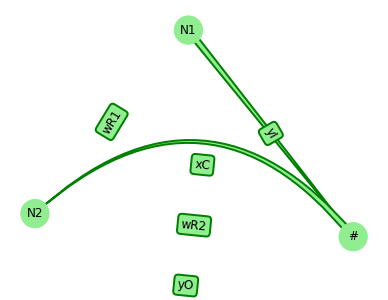

In [20]:
graph.analysis.plot()           # plot minimum spanning tree

## 4. Define control parameters
* Control parameters can be modified at runtime.
* Below, we change a fix resistance to a potentiometer.

In [21]:
pfc, C, R1 = core.symbols(['pfc', 'C', 'R1'])  # define some symbols

In [22]:
fref = 20
cutoff = fref*10**(3*pfc)           # pfc in [0, 1] => cutoff in [2e1, 2e4]
rc = 1/(2*3.14157*cutoff*C)         # resistance = 1/(2*pi*cutoff*C)

In [23]:
core.subs[R1] = rc                  # substitute symbol R1 by expression rc
core.substitute(selfexprs=True)     # substitute symbols by expressions
core.add_parameters(pfc)            # add pfc to the list of control parameters

In [24]:
core.pprint()                                  # Show

⎡       ⎡             3⋅pfc     1.0                   3⋅pfc   ⎤       ⎤
⎢       ⎢- 125.6628⋅10     ⋅C - ───  -1.0  125.6628⋅10     ⋅C ⎥       ⎥
⎢⎡dxC⎤  ⎢                        R₂                           ⎥  ⎡gxC⎤⎥
⎢⎢   ⎥  ⎢                                                     ⎥  ⎢   ⎥⎥
⎢⎢yO ⎥, ⎢           1.0               0             0         ⎥, ⎢uO ⎥⎥
⎢⎢   ⎥  ⎢                                                     ⎥  ⎢   ⎥⎥
⎢⎣yI ⎦  ⎢               3⋅pfc                          3⋅pfc  ⎥  ⎣uI ⎦⎥
⎣       ⎣    125.6628⋅10     ⋅C       0    -125.6628⋅10     ⋅C⎦       ⎦


## 5. I/O simulations

In [25]:
import os
label = 'lowpass'
config = {'fs': 48e3,                                # sample rate (Hz)
          'path': os.path.join(os.getcwd(), label),  # folder for output results
         }
simu = core.to_simulation(config=config)             # `Simulation` object.

In [26]:
T = 2.                                     # simulation time (s)
nt = int(T*config['fs'])                   # number of time steps (int)

### Input $\mathbf u$

In [27]:
from pyphs import signalgenerator
config_isig = {'which': 'noise',         # signal type is noise (amplitude 1)
               'tsig': T,                # signal duration (s)
               'fs': config['fs']}       # signal sample rate (Hz)
isig = signalgenerator(**config_isig)    # build Python generator

In [28]:
simu.method.u                            # get inputs ordering

In [29]:
# generator passed as an argument to `Simulation.init`
def u():
    """
    Generator (0, vi) for vi in isig
    """
    for vI_ in isig():
        yield (0., vI_)

### Parameter $\mathbf p$

In [30]:
config_pfcsig = {'which': 'const',           # signal type is constant
                'A': 1.,                     # amplitude is 1
                'tsig': T,                   # signal duration (s)
                'fs': config['fs'],          # signal sample rate (Hz)
                'ramp_on': True}             # linear increase
pfcsig = signalgenerator(**config_pfcsig)    # build Python generator

In [31]:
# generator passed as an argument to `Simulation.init`
def p():
    """
    Generator (pfc,) for pfc in pfcsig
    """
    for pfc_ in pfcsig():
        yield pfc_,

In [32]:
simu.init(u=u(), p=p(), nt=nt)     # initialize `Data` object
simu.process()                     # process

/Users/afalaize/Developement/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


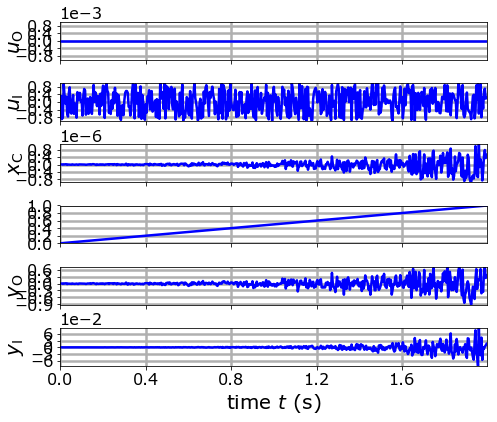

In [33]:
simu.data.plot(('u', 'x', 'p', 'y'), load={'decim':int(nt/500.)})

In [34]:
vector = 'y'         # in ['x', 'dx', 'dxH', 'w', 'z', 'u', 'y']
index = 0            # index in chosen vector

# wav file path without '.wav' extension
path = os.path.join(simu.config['path'], label+'_out') 
simu.data.wavwrite(vector, index, 
                   path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto2_lowpass/lowpass/lowpass_out
Convert generator to list...
Fade begining and ending...
Write wave file...


In [35]:
vector = 'u'         # in ['x', 'dx', 'dxH', 'w', 'z', 'u', 'y']
index = 1            # index in chosen vector

# wav file path without '.wav' extension
path = os.path.join(simu.config['path'], label+'_in') 
simu.data.wavwrite(vector, index, 
                   path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/TUTOS/PyPHS_tuto2_lowpass/lowpass/lowpass_in
Convert generator to list...
Fade begining and ending...
Write wave file...


## Additionnally: Code generation
Below we give routines to generate
* C++ simulation code
* Faust `.dsp` code
* Juce C++ snippets

### C++ code
Generate a core C++ object:
* `core.h`, `core.cpp`, 
* `parameters.h`, `parameters.h`.

In [36]:
# Define output folder
objlabel = 'lowpass'
cppfolder = os.path.join(os.getcwd(), label, 'src')

In [37]:
# `Core` object to `Method`
method = core.to_method()

In [38]:
method.to_cpp(objlabel=objlabel, path=cppfolder)

### Faust code
Generate a Faust `.dsp` to use in the [Faust compiler](http://faust.grame.fr/onlinecompiler/).

In [39]:
# path to generated .dsp file
label = 'lowpass'
dsppath = os.path.join(os.getcwd(), label, label+'.dsp')

In [40]:
# Select inputs: list of constant values and input labels
# Here, we select input as 'uI' and set 'uO' to constant 0
inputs = (0., 'uI')

In [41]:
# Select outputs: list of outputs labels
outputs = ('yO', )

In [42]:
from pyphs import core2faustfx
core2faustfx(core, path=dsppath, inputs=inputs, outputs=outputs)

### Juce snippets
* Generate a set of pieces of code to be inserted in a Juce template.
* Also generate the c++ core object.

In [43]:
# `Core` object to `Method`
method = core.to_method()

In [44]:
# Define output folder
objlabel = 'lowpass'
jucefolder = os.path.join(os.getcwd(), label, 'juce')

In [45]:
# Here, we select input as 'uI' and output as 'yO'
io = (('uI', ),  ('yO', ))

In [46]:
from pyphs.misc.juce import fx
fx.method2jucefx(method, objlabel=objlabel, path=jucefolder, io=io)